## Toggling the raw codes: 

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

## Importing Libraries and connecting to SQL:

In [10]:
import pyodbc 
import psycopg2
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.stats import pearsonr
import getpass

In [11]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
def open_connection(dbname,user,pwd,host_name,port ):
    conn = psycopg2.connect(database = dbname, user = user, password = pwd, host = host_name, port = port)
    print ("Connected successfully")
    return conn

In [7]:
def run_sql_code(sql_stmnt,conn) : 
    cursor = conn.cursor()
    cursor.execute( sql_stmnt )
    
    if cursor.pgresult_ptr is not None:
        sql_table = cursor.fetchall()
        column_names = [desc[0] for desc in cursor.description]
        sql_table_df =  pd.DataFrame(sql_table,columns = (column_names))
    else:
        sql_table_df =  "No table rows selected"

    return(sql_table_df)

### Connecting to SQL server 
Enter password to connect to the Samarth Prod server : 

In [12]:
dbname ="postgres"
user = "postgres"
host_name = "139.59.46.189"
port = "6432"
pwd= getpass.getpass()

········


In [48]:
conn = open_connection(dbname,user,pwd,host_name,port )

Connected successfully


### User defined functions for clustering:

In [ ]:
def clustering_subj(students_2exams_data_stud_subj_lvl,subject_name): 
    Maths_students_2exams_data_stud_subj_lvl = students_2exams_data_stud_subj_lvl.loc[students_2exams_data_stud_subj_lvl['subject_desc']== subject_name,:]
    clustering_data = Maths_students_2exams_data_stud_subj_lvl[['assessment_percent_all','percentile_score_stud']].copy()
    scaler = StandardScaler().fit(clustering_data)
    standardized_clustering_data = scaler.transform(clustering_data)
    k = 4
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(standardized_clustering_data)
    cluster_plot_df =  pd.DataFrame(clustering_data.copy())
    cluster_plot_df['Cluster']= kmeanModel.labels_
    cluster_plot_df.columns = ('Mean Assessment Percent', 'SD of percentile','Cluster')
    #cluster_plot_df = cluster_numbering(cluster_plot_df)
    cluster_data_results = cluster_plot_df.copy()
    replacing_dictionary = dict.fromkeys([0, 1, 2, 3])
    cluster_data_results_agg =  cluster_data_results.groupby(['Cluster']).agg({'Mean Assessment Percent':'mean','SD of percentile':'mean'}).reset_index()
    cluster_array = np.array([cluster_data_results_agg.loc[cluster_data_results_agg['Mean Assessment Percent'] == min(cluster_data_results_agg['Mean Assessment Percent']),'Cluster'].values[0],
        cluster_data_results_agg.loc[cluster_data_results_agg['SD of percentile'] == max(cluster_data_results_agg['SD of percentile']),'Cluster'].values[0],
        cluster_data_results_agg.loc[cluster_data_results_agg['Mean Assessment Percent'] == max(cluster_data_results_agg['Mean Assessment Percent']),'Cluster'].values[0]
         ])
    new_array= np.array([None,None,None,None])
    new_array[[0,2,3]]= cluster_array
    new_array[1]= np.array([0,1,2,3])[~np.isin(np.array([0,1,2,3]),  cluster_array)][0]
    new_array[1]= np.array([0,1,2,3])[~np.isin(np.array([0,1,2,3]),  cluster_array)][0]
    Cluster_mapping_df = pd.DataFrame(new_array,columns=['Old_Cluster_id'])
    Cluster_mapping_df['New_Cluster_id']= Cluster_mapping_df.index
    cluster_data_results1=  cluster_data_results.merge(Cluster_mapping_df, how='left', left_on = 'Cluster', right_on= 'Old_Cluster_id')
    cluster_data_results1= cluster_data_results1.drop(['Cluster','Old_Cluster_id'], axis = 1)
    cluster_data_results1 = cluster_data_results1.rename(columns = {"New_Cluster_id":"Cluster"})
    cluster_plot_df = cluster_data_results1.copy()
    cluster_plot_df['student_id'] = Maths_students_2exams_data_stud_subj_lvl.reset_index()['student_id']
    cluster_plot_df['school_id'] = Maths_students_2exams_data_stud_subj_lvl.reset_index()['school_id']
    return (cluster_plot_df)

## Creating the datasets: 

### Pulling from SQL : 

The required dataset is pulled from the prod Samarth DB.  
The data is being pulled for Grade 7 and for Shimla district. 
They have data only for FA1,FA2,SA1 and SA2.  
The SQL code is based on the EDA done for new dataset-Samarth DB. 

In [49]:
sql_stmnt =  '''Select ab.*,RANK() OVER(PARTITION BY assessment_id,Subject_desc,subm_grade_number 
        ORDER BY assessment_percent_all DESC) as grade_number,
        COUNT(*) OVER  (PARTITION BY  assessment_id,Subject_desc,subm_grade_number ) as frequency,

round((100-(RANK() OVER(PARTITION BY assessment_id,Subject_desc,subm_grade_number 
        ORDER BY assessment_percent_all DESC) *100.000) / 
        COUNT(*) OVER  (PARTITION BY  assessment_id,Subject_desc,subm_grade_number )),3) as percentile_Score_Stud, 
        CASE WHEN assessment_percent_all < 40 THEN 1 ELSE 0 END AS pass_fail,
attendance_record.days,
attendance_record.present_days,
round(attendance_record.present_days/ attendance_record.days,2) as attendance_percent

    from     
    (select school_id,student_id,subm_grade_number,assessment_type,Subject_desc,assessment_id, 
    sum(assessment_total_marks) as assessment_total_marks,
    CASE WHEN sum(assessment_marks) < 0 THEN 0 ELSE sum(assessment_marks) END as assessment_marks , 
	CASE WHEN sum(assessment_marks) < 0 THEN 0 ELSE  round((sum(assessment_marks)/sum(assessment_total_marks)),3) END as assessment_percent_all 
    FROM 
        (   select 
        school.id as school_id, base.student_id,base.assessment_id, subject.name as Subject_desc,grade.number as subm_grade_number ,
        component_type.name as component_name,
        assessment_type.abbreviation as assessment_type,
        round(cast(avg(component.max_marks) as int),0) as assessment_total_marks,
        round(cast(avg(component_submission.assessment_marks) as int),0) as  assessment_marks
         --component_submission.assessment_marks*100.00/component.max_marks  as assessment_percent,
          from  student_submission_v2 base
        left join student_submission_v2_marks_submissions on base.id =  student_submission_v2_marks_submissions.studentsubmission_v2_id
        left join component_submission on student_submission_v2_marks_submissions.componentsubmission_id =  component_submission.id
        left join component on component_submission.component_id =  component.id
        left join component_type on component.component_type_id =  component_type.id
        left join grade on base.grade_id = grade.id 
        left join student on base.student_id  = student.id
        left join school on student.school_id = school.id
        left join assessment on base.assessment_id =  assessment.id   
        left join assessment_type on  assessment.type_v2_id  = assessment_type.id
        left join deadline on assessment.deadline_id =  deadline.id
        left join subject on base.subject_id =  subject.id 
        left join location  on school.location_id = location.id
        where student.is_enabled = 't'
        and school.is_active =  't'
        and school.udise > 1111111111 
        and location.district = 'SHIMLA'
        and grade.number in ('7')
        group by school.id,base.student_id, base.assessment_id, subject.name,grade.number,assessment_type.abbreviation ,component_type.name
        ) a
    group by school_id,student_id,subm_grade_number,assessment_type,Subject_desc,assessment_id
    ) ab
    
LEFT JOIN   
    (select student_id,
    count(*) as days, 
    sum(CASE WHEN is_present = 't' THEN 1 ELSE 0 END) as present_days
    from attendance 
    where attendance.student_id in (
    select  base.student_id 
                  from  student_submission_v2 base
                left join grade on base.grade_id = grade.id 
                left join student on base.student_id  = student.id
                left join school on student.school_id = school.id
                left join location  on school.location_id = location.id
                where student.is_enabled = 't'
                and school.is_active =  't'
                and school.udise > 1111111111 
                and location.district = 'SHIMLA'
                and grade.number in ('7'))
    group by student_id) attendance_record
    
    ON ab.student_id = attendance_record.student_id
    
'''

df = run_sql_code(sql_stmnt,conn)

In [50]:
base_df_marks_8 = df.copy()

### Filtering on the students: 

- Only considering students who have written at least 2 assessments 

### Preparing clustering data 

- Calculating the mean percentage and the standard deviation of the percentile. The clustering method is discussed in 'Clustering Use Case- Samarth' data notebook

In [51]:
### seperating out students who have written at least 2 exams 
base_df_marks_8['grade_assestype'] = base_df_marks_8['subm_grade_number'].astype('str') + base_df_marks_8['assessment_type']
years_students = base_df_marks_8.groupby(['student_id']).agg({'subm_grade_number':'nunique', 'grade_assestype':'nunique'}).reset_index()
#years_students.groupby(['subm_grade_number','grade_assestype']).agg({'student_id':'nunique'}).reset_index()
students_2exams_students =  years_students.loc[years_students['grade_assestype'] >= 2,'student_id']
students_2exams_data = base_df_marks_8.loc[ base_df_marks_8['student_id'].isin(students_2exams_students.values),:]

## aggregatting at a student level taking the average of marks and the sd of percentile 
students_2exams_data['assessment_percent_all'] = students_2exams_data['assessment_percent_all'].astype('float')
students_2exams_data['percentile_score_stud'] = students_2exams_data['percentile_score_stud'].astype('float')
students_2exams_data_stud_subj_lvl = students_2exams_data.groupby(['school_id','student_id','subject_desc']).agg({'assessment_percent_all':'mean','percentile_score_stud':'std'}).reset_index()
students_2exams_data_stud_subj_lvl = students_2exams_data_stud_subj_lvl.loc[~students_2exams_data_stud_subj_lvl['percentile_score_stud'].isnull(),:]

### Carrying out clustering and creating metrics

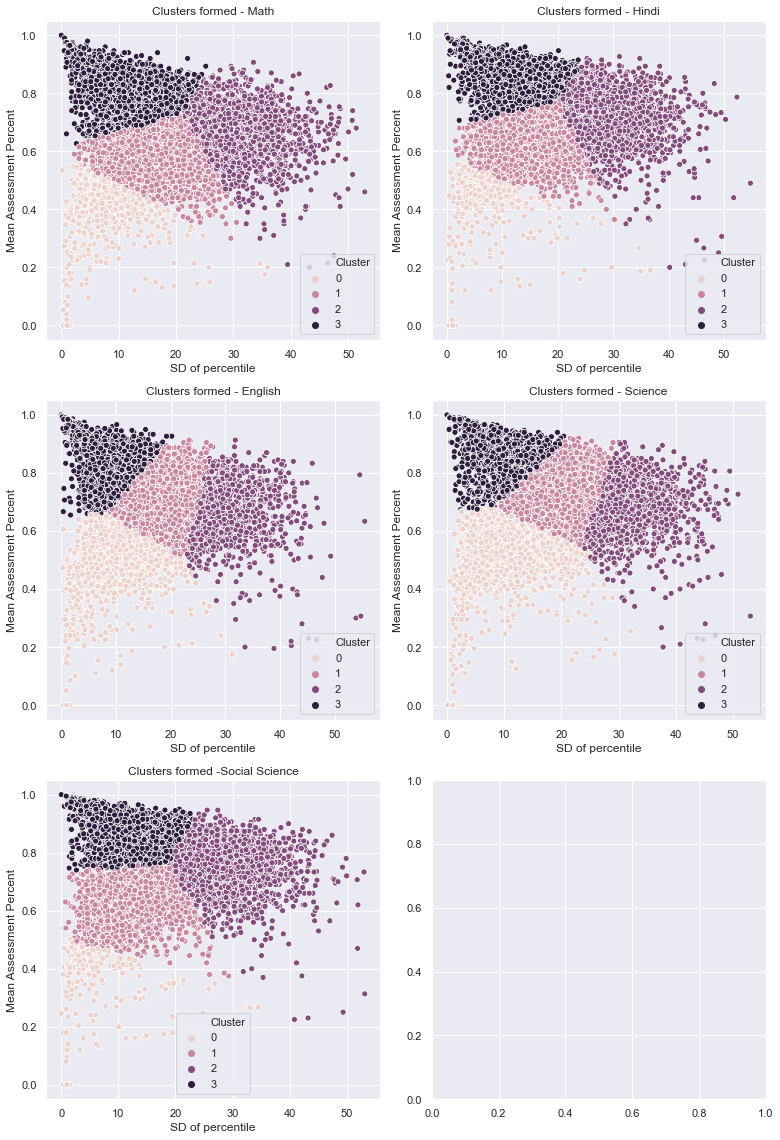

In [37]:
##carrying out he clustering: 

Math_clus_data =  clustering_subj(students_2exams_data_stud_subj_lvl,'Mathematics')
SSc_clus_data = clustering_subj(students_2exams_data_stud_subj_lvl,'Social Science')
Eng_clus_data = clustering_subj(students_2exams_data_stud_subj_lvl,'English')
Sc_clus_data = clustering_subj(students_2exams_data_stud_subj_lvl,'Science')
Hindi_clus_data = clustering_subj(students_2exams_data_stud_subj_lvl,'Hindi')

sns.set(rc={'figure.figsize':(11,16)})
fig, axs = plt.subplots(3,2)
sns.scatterplot( x='SD of percentile', y='Mean Assessment Percent', data=Math_clus_data, hue="Cluster",ax = axs[0][0]).set(title='Clusters formed '+ '- Math')

sns.scatterplot( x='SD of percentile', y='Mean Assessment Percent', data=SSc_clus_data, hue="Cluster",ax = axs[0][1]).set(title='Clusters formed '+ '- Hindi')

sns.scatterplot( x='SD of percentile', y='Mean Assessment Percent', data=Eng_clus_data, hue="Cluster",ax = axs[1][0]).set(title='Clusters formed '+ '- English')

sns.scatterplot( x='SD of percentile', y='Mean Assessment Percent', data=Sc_clus_data, hue="Cluster",ax = axs[1][1]).set(title='Clusters formed '+ '- Science')

sns.scatterplot( x='SD of percentile', y='Mean Assessment Percent', data=Hindi_clus_data, hue="Cluster",ax = axs[2][0]).set(title='Clusters formed '+ '-Social Science')

fig.tight_layout()
plt.show()

### Collating clustering data and combining with other student info : 

In [38]:
### combining all the results into one table  :  

Math_clus_data['subject_desc']= 'Mathematics'
SSc_clus_data['subject_desc'] = 'Social Science'
Eng_clus_data['subject_desc'] = 'English'
Sc_clus_data['subject_desc'] = 'Science'
Hindi_clus_data['subject_desc'] = 'Hindi'

All_subject_clusters =  pd.concat([Math_clus_data.reset_index(drop=True), 
           SSc_clus_data.reset_index(drop=True),
           Eng_clus_data.reset_index(drop=True),
           Sc_clus_data.reset_index(drop=True),
           Hindi_clus_data.reset_index(drop=True) ], axis=0)

#### Creating student level cluster subject combinations :
For each cluster, I've calculated the combinations of subject for each student belongs to that cluster.  

For example, If a student belongs to the top cluster (cluster 3) in all the subjects, then for cluster 3 it should show 'English, Maths, Social Science, Hindi, Science' against him but if he belongs to the top cluster onnly for Engish and Hindi and not for other subjects, then it should show 'English,Hindi' against him.  

This will be useful in creating separate groups of students for the remedial classess/ speical programs and holding classes for them parallely.  
For example, if there are 10 students in cluster 0 across all subjects and 6 of them are in cluster 0 for Hindi, English and 4 of them in Science, Maths. Then one can hold parallell sessions for these students

In [39]:
## creating the subject combinations for clusters: 
All_subject_clusters.loc[All_subject_clusters['subject_desc'] == 'Mathematics','Subject_code'] =1
All_subject_clusters.loc[All_subject_clusters['subject_desc'] == 'Science','Subject_code'] =2
All_subject_clusters.loc[All_subject_clusters['subject_desc'] == 'Social Science','Subject_code'] =4
All_subject_clusters.loc[All_subject_clusters['subject_desc'] == 'English','Subject_code'] =8
All_subject_clusters.loc[All_subject_clusters['subject_desc'] == 'Hindi','Subject_code'] =16

In [40]:
All_subject_clusters['subjects_cluster']=  All_subject_clusters.groupby(['Cluster','student_id']).Subject_code.transform(np.sum)
subject_combos =  All_subject_clusters[['Subject_code','subjects_cluster','subject_desc']].drop_duplicates()
subject_combos = subject_combos.groupby(['subjects_cluster'], as_index = False).agg({'subject_desc': ' , '.join}).reset_index()
subject_combos = subject_combos.rename(columns ={'subject_desc': 'subject_combination'})
All_subject_clusters = pd.merge(All_subject_clusters, subject_combos,how= 'left', left_on=['subjects_cluster'], right_on = ['subjects_cluster'])
## adding class rank
All_subject_clusters['class_subj_rank'] = All_subject_clusters.groupby(['school_id','subject_desc'])['Mean Assessment Percent'].rank(ascending=False,method = 'min')

In [54]:
All_subject_clusters_req_cols =  All_subject_clusters[['student_id','subject_desc','Cluster', 'subject_combination','class_subj_rank']]

In [77]:
base_df_marks_8_all =  pd.merge(base_df_marks_8,All_subject_clusters_req_cols, how= 'left', left_on=['student_id','subject_desc'], right_on = ['student_id','subject_desc']  )

In [78]:
base_df_marks_8_all.loc[base_df_marks_8_all['days'].isnull(),['days','present_days','attendance_percent']] = 0.0

#### Adding LO information to the students:  

Each assessment is connected to LO buckets which are in turn connected to multiple LO's.
We can calculate the scores for each of the LOs on this basis and over many assessments calculate what is the worst perfroming and best performing LOs

In [91]:
sql_stmnt = '''SELECT distinct assessment_lo_bundles.assessment_id,
    assessment_lo_bundles.lobundle_id,
    lo_v2.code as LO_code,
    lo_v2.name as LO_name,
    subject.name as LO_subject
    FROM assessment_lo_bundles 
    left join lo_bundle_los 
        on assessment_lo_bundles.lobundle_id = lo_bundle_los.lobundle_id
    left join lo_v2 
        on lo_bundle_los.lo_v2_id =  lo_v2.id 
    left join subject 
        on lo_v2.subject_id =  subject.id
    WHERE assessment_id IN 
        (select distinct base.assessment_id 
              from  student_submission_v2 base
            left join student_submission_v2_marks_submissions on base.id =  student_submission_v2_marks_submissions.studentsubmission_v2_id
            left join component_submission on student_submission_v2_marks_submissions.componentsubmission_id =  component_submission.id
            left join component on component_submission.component_id =  component.id
            left join component_type on component.component_type_id =  component_type.id
            left join grade on base.grade_id = grade.id 
            left join student on base.student_id  = student.id
            left join school on student.school_id = school.id
            left join assessment on base.assessment_id =  assessment.id   
            left join assessment_type on  assessment.type_v2_id  = assessment_type.id
            left join deadline on assessment.deadline_id =  deadline.id
            left join subject on base.subject_id =  subject.id 
            left join location  on school.location_id = location.id
            where student.is_enabled = 't'
            and school.is_active =  't'
            and school.udise > 1111111111 
            and location.district = 'SHIMLA'
            and grade.number in ('7'))'''
df = run_sql_code(sql_stmnt,conn)

In [92]:
lo_info  = df.copy ()

### Saving the dataset : 

In [96]:
base_df_marks_8_all.to_csv('D:/Samagra/Samarth LR/PBI report/ads_7th_grade.csv')

In [93]:
lo_info.to_csv('All_students_LO.csv')